## Basic analysis for Sephora foundation reviews

In [16]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
reviews = pd.read_csv("./data/sephora_reviews_final.csv")

In [7]:
reviews.shape

(275950, 28)

In [6]:
reviews.columns.tolist()

['brand',
 'name',
 'product_id',
 'coverage',
 'finish',
 'formulation',
 'normal_skin',
 'oily_skin',
 'combo_skin',
 'dry_skin',
 'SPF',
 'user_name',
 'rating',
 'recommended',
 'skin_type',
 'eye_color',
 'skin_tone',
 'skin_concerns',
 'age',
 'beauty_insider',
 'price',
 'first_submission_date',
 'last_submission_date',
 'location',
 'incentivized_review',
 'review_text',
 'brand_image_url',
 'product_image_url']

### About the dataset:

In total, our dataset consists of 275,950 foundation reviews with 28 different columns. These columns include brand, name, product id, coverage, foundation, finish, formulation, normal skin, oily skin, combo skin, dry skin, SPF, username, rating, recommend, skin type, eye color, skin tone, skin concerns, age, beauty insider, price, first submission date, last submission date, location, incentivized review, review text, brand image url, and product image url. For our purposes, we will not need to analyze every columns, but we do have comprehensive information on user preferences and profiles (i.e. age, skin type, location, rating, recommendation) , as well as product information (coverage, finish, price).

In [8]:
reviews.sample(3)

,brand,name,product_id,coverage,finish,formulation,normal_skin,oily_skin,combo_skin,dry_skin,SPF,user_name,rating,recommended,skin_type,eye_color,skin_tone,skin_concerns,age,beauty_insider,price,first_submission_date,last_submission_date,location,incentivized_review,review_text,brand_image_url,product_image_url
42682,HUDA BEAUTY,#FauxFilter Foundation,P424302,NaN,NaN,NaN,False,False,False,False,False,jcog11,5,True,oily,brown,medium,aging,NaN,NaN,40.0,2018-04-09 15:11:48,2018-04-09 15:15:09,NaN,NaN,I have been trying many foundations for years ...,/contentimages/brands/huda/huda_logo_search_09...,https://www.sephora.com/productimages/sku/s200...
92801,bareMinerals,COMPLEXION RESCUE™ Tinted Moisturizer Broad Sp...,P393356,NaN,NaN,NaN,False,False,False,False,True,MitziLSupper,4,True,oily,brown,medium,acne,NaN,NaN,30.0,2018-11-19 15:36:10,2018-11-19 15:45:03,NaN,NaN,Love this light and dewy finish. Perfect for e...,/contentimages/brands/bareescentuals/082212_ba...,https://www.sephora.com/productimages/sku/s168...
63747,Kat Von D,Lock-It Foundation,P311138,Full,Matte,Liquid,True,True,True,True,False,PrincessCrown,5,NaN,normal,brown,medium,NaN,45to54,no,35.0,2014-05-26 12:34:36,2014-05-26 12:45:04,"Perth, Western Australia",NaN,"Love, love, love this product - covers well - ...",/contentimages/brands/katvond/KatVonD_Logo_101...,https://www.sephora.com/productimages/sku/s139...


In [9]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275950 entries, 0 to 275949
Data columns (total 28 columns):
brand                    275950 non-null object
name                     275950 non-null object
product_id               275950 non-null object
coverage                 188124 non-null object
finish                   187098 non-null object
formulation              154297 non-null object
normal_skin              275950 non-null bool
oily_skin                275950 non-null bool
combo_skin               275950 non-null bool
dry_skin                 275950 non-null bool
SPF                      275950 non-null bool
user_name                273010 non-null object
rating                   275950 non-null int64
recommended              81707 non-null object
skin_type                134363 non-null object
eye_color                177496 non-null object
skin_tone                182847 non-null object
skin_concerns            70865 non-null object
age                      119546 non-nu

### Missingness

We should also try and get an idea of our data--what do we have and what are we missing?

We can see that we have most of the important information: brand, name/product id, rating, price, and review text, as well as some other secondary information.

In [10]:
# Seems like we have most pertinent information
reviews.columns[reviews.isna().sum(axis = 0) == 0]

Index(['brand', 'name', 'product_id', 'normal_skin', 'oily_skin', 'combo_skin',
       'dry_skin', 'SPF', 'rating', 'price', 'first_submission_date',
       'last_submission_date', 'review_text', 'brand_image_url',
       'product_image_url'],
      dtype='object')

In [79]:
reviews.isna().sum(axis = 0)[reviews.isna().sum(axis = 0) > 0]/len(reviews)*100

coverage               31.826780
finish                 32.198587
formulation            44.085160
user_name               1.065410
recommended            70.390650
skin_type              51.308933
eye_color              35.678203
skin_tone              33.739083
skin_concerns          74.319623
age                    56.678384
beauty_insider         59.779308
location               58.768255
incentivized_review    71.218337
dtype: float64

### Descriptive Statistics

In [13]:
reviews.describe()

,rating,price
count,275950.000000,275950.000000
mean,4.123794,39.847969
std,1.255406,9.472592
min,1.000000,18.000000
25%,4.000000,34.000000
50%,5.000000,39.000000
75%,5.000000,45.000000
max,5.000000,120.000000


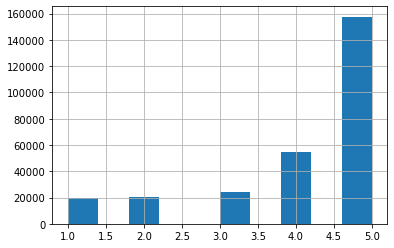

In [39]:
reviews["rating"].hist()

We have 217 distinct foundations, coming from 63 different brands -- 14 for you Clinique, you go Clinique!

In [32]:
reviews[["brand", "name"]].drop_duplicates().describe()

,brand,name
count,217,217
unique,63,217
top,CLINIQUE,Nothing Beats the Original™ Complexion Kit
freq,14,1


In [54]:
reviews[reviews["brand"] == "CLINIQUE"][["name"]].drop_duplicates()

,name
165422,Even Better Makeup SPF 15
176528,Beyond Perfecting Foundation + Concealer
207580,Stay-Matte Sheer Pressed Powder
232237,Stay-Matte Oil-Free Makeup
233480,Moisture Surge CC Cream Hydrating Colour Corre...
235267,Acne Solutions BB Cream Broad Spectrum SPF 40
236162,Superpowder Double Face Makeup
243000,Acne Solutions Liquid Makeup
255177,Superbalanced Makeup
265054,Even Better™ Glow Light Reflecting Makeup Broa...


It does not surprise me that La Mer has a \\$120 foundation. It does surprise me that Giorgio Armani does, but I guess it's also a high-end brand. Sephora's in-house brand is the cheapest, which is unsurprising. One thing that this dataset failed to collect is the product size (i.e. fl oz.). Most foundations are 1 fl. oz., but there is some variability that could make a foundation more (or less expensive) than expected.

In [83]:
reviews[["brand", "name", "price"]].drop_duplicates().sort_values(by="price", ascending = False)

,brand,name,price
270849,Giorgio Armani Beauty,Crema Nuda,120.0
206074,La Mer,The Soft Fluid Long Wear Foundation SPF 20,120.0
206272,La Mer,The Luminous Lifting Cushion Foundation SPF 20...,120.0
192642,TOM FORD,Traceless Foundation Stick,87.0
258420,TOM FORD,Traceless Perfecting Foundation Broad Spectrum...,87.0
265980,TOM FORD,Traceless Foundation Broad Spectrum SPF 15,87.0
244734,TOM FORD,Waterproof Foundation & Concealer,87.0
222585,Dior,Capture Dreamskin Fresh & Perfect Cushion Broa...,82.0
256067,Koh Gen Do,Aqua Foundation,70.0
267347,AMOREPACIFIC,MOISTURE BOUND Tinted Treatment Moisturizer SP...,70.0


The average foundation price is \\$44.71, the cheapest being \\$18 and the priciest being \\$120, with a standard deviation of \\$15.02. Again, the foundation prices don't surprise me much since these are pretty consistent with what we would find at Sephora, which houses mainly mid-range to high-end brands.

In [86]:
reviews[["brand", "name", "price"]].drop_duplicates().describe()

,price
count,217.000000
mean,44.714286
std,15.016547
min,18.000000
25%,37.000000
50%,42.000000
75%,49.000000
max,120.000000


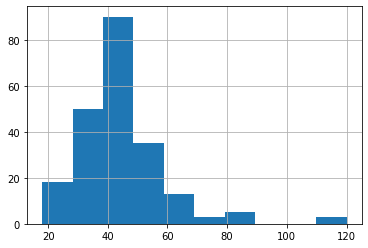

In [87]:
reviews[["brand", "name", "price"]].drop_duplicates()["price"].hist()

In [84]:
pd.concat([reviews[["brand", "name"]], reviews["price"].astype(str)], axis = 1).drop_duplicates().describe()

,brand,name,price
count,217,217,217
unique,63,217,47
top,CLINIQUE,Nothing Beats the Original™ Complexion Kit,42.0
freq,14,1,18


In [91]:
reviews[["brand", "name", "finish"]].drop_duplicates()

,brand,name,finish
0,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,Matte
11681,MAKE UP FOR EVER,Ultra HD Invisible Cover Foundation,Natural
11703,MAKE UP FOR EVER,Ultra HD Invisible Cover Foundation,NaN
20825,Giorgio Armani Beauty,Luminous Silk Foundation,Natural
20831,Giorgio Armani Beauty,Luminous Silk Foundation,NaN
23290,Estée Lauder,Double Wear Stay-in-Place Foundation,Matte
27913,IT Cosmetics,Your Skin But Better™ CC+™ Cream with SPF 50+,Natural
30559,Too Faced,Born This Way Foundation,Radiant
37893,Lancôme,Teint Idole Ultra Long Wear Foundation,NaN
37922,Lancôme,Teint Idole Ultra Long Wear Foundation,Matte


In [102]:
reviews.groupby(["age"]).agg({"rating": "mean"})

,rating
age,
13to17,4.095059
18to24,4.176917
25to34,4.247018
35to44,4.312902
45to54,4.429192
over54,4.433520


In [7]:
reviews.describe(include = ["O"])

,brand,name,product_id,coverage,finish,formulation,user_name,recommended,skin_type,eye_color,skin_tone,skin_concerns,age,beauty_insider,first_submission_date,last_submission_date,location,incentivized_review,review_text,brand_image_url,product_image_url
count,275950,275950,275950,188124,187098,154297,273010,81707,134363,177496,182847,70865,119546,110989,275950,275950,113779,79423,275950,275950,275950
unique,63,217,217,3,3,6,206386,2,4,5,9,15,6,4,263462,145820,20502,2,263406,63,2995
top,bareMinerals,Original Foundation Broad Spectrum SPF 15,P61003,Medium,Matte,Liquid,ashley26,True,combination,brown,light,acne,25to34,yes,2013-08-28 19:11:26,2017-12-21 19:16:19,"New York, NY",False,What a wonderful product this powder foundatio...,/contentimages/brands/bareescentuals/082212_ba...,https://www.sephora.com/productimages/sku/s192...
freq,36814,19292,19292,96283,85560,105485,63,64632,70739,91257,55695,37509,42920,80476,5,433,3065,75319,42,36814,19025


In [25]:
# OF COURSE LA MER IS THE MOST EXPENSIVE FOUNDATION. And Giorgio Armani
reviews[reviews["price"]==max(reviews["price"])]["brand"].unique()

array(['La Mer', 'Giorgio Armani Beauty'], dtype=object)

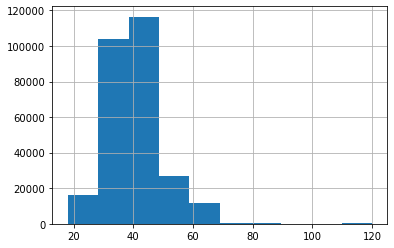

In [27]:
reviews["price"].hist()

In [40]:
tags = pd.read_csv("./data/Sephora_Foundation_Tags.csv")

In [100]:
#tags["Value"].value_counts().hist()

In [101]:
#tags.groupby(["brand"]).agg({"Value": lambda x:x.value_counts()[0]})

In [102]:
#tags[["brand", "product"]]